In [1]:
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm
import re
from os import listdir

%matplotlib inline
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
# Load line profile Analysis Results
grps = ['DMSO','Taxol','5ITu']
df_res_list = []

for grp in grps:
    df_res = pd.read_json('AnalysisResults/Dist_vs_INCENP_analysis_%s.json' %grp)
    df_res_list.append(df_res)


In [3]:
df_res_list[2]['Npairs'].sum()

680

In [4]:
# import FLIM data mat files
from scipy import io
mat = io.loadmat('dist_all_result_bin8_WT.mat')
FLIMWT = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten(),
         'Xq1':mat['Xq1'][0][0].flatten(),'Xq3':mat['Xq3'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin8_Treated.mat')
FLIM5ITu = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten(),
            'Xq1':mat['Xq1'][0][0].flatten(),'Xq3':mat['Xq3'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin4_Taxol.mat')
FLIMTaxol = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten(),
             'Xq1':mat['Xq1'][0][0].flatten(),'Xq3':mat['Xq3'][0][0].flatten()}

mat = io.loadmat('dist_all_result_bin3_DblTreated.mat')
FLIMDbl = {'edges':mat['Edge'][0][0].flatten(),'mean_FRET_fraction':mat['mean_Y_dist'][0][0].flatten(),
          'std_FRET_fraction':mat['std_Y_dist'][0][0].flatten(),'X':mat['X'][0][0].flatten(),
             'Xq1':mat['Xq1'][0][0].flatten(),'Xq3':mat['Xq3'][0][0].flatten()}



In [5]:
pixsize = 8190/60/1.5/1.2/512 #um
convfactor = 0.42   #FRET fraction  -> binding conversion factor
AuroraPeakConc = 10     #Aurora B peak concentration (from Zaytsev et al Elife)

[ 8.  2.  2.  2.  1.  2.  2.  1.]


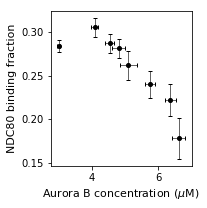

In [6]:
# plot NDC80 Binding fraction vs Aurora B level (in real concentration), bin average

FLIM_list = [FLIMWT,FLIMTaxol,FLIM5ITu]

ms=4
ew=0.6
convfactor = 0.42   #FRET fraction  -> binding conversion factor
#dconvfactor = 0.08 #error in conversion factor
AuroraPeakConc = 10     #Aurora B peak concentration (from Zaytsev et al Elife)
fs = 11

# bin average the NDC80 binding fraction vs Aurora B level plot
X = np.concatenate([df_res['avgnormint560'].values for df_res in df_res_list])
dX = np.concatenate([df_res['semnormint560'].values for df_res in df_res_list])
Y = np.concatenate([df['mean_FRET_fraction']/convfactor for df in FLIM_list])
dY = np.concatenate([df['std_FRET_fraction']/convfactor for df in FLIM_list])

edges = [0.25,0.35,0.45,0.465,0.5,0.55,0.6,0.65,0.7]
meanX = np.zeros(len(edges)-1)
semX = np.zeros(len(edges)-1)
meanY = np.zeros(len(edges)-1)
semY = np.zeros(len(edges)-1)
N = np.zeros(len(edges)-1)
for i in range(len(edges)-1):
    sel = (X<edges[i+1]) & (X>=edges[i])
    meanX[i] = (X[sel]/dX[sel]**2).sum()/(1/dX[sel]**2).sum()  #weighted average
    semX[i] = np.sqrt(1/(1/dX[sel]**2).sum())
    meanY[i] = (Y[sel]/dY[sel]**2).sum()/(1/dY[sel]**2).sum()  #weighted average
    semY[i] = np.sqrt(1/(1/dY[sel]**2).sum())
    N[i] = (sel).sum()

print(N)
fig = plt.figure(figsize=(3,3))
plt.errorbar(meanX*AuroraPeakConc,meanY,
             xerr=semX*AuroraPeakConc,yerr=semY,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)

plt.xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)
plt.ylabel('NDC80 binding fraction',fontsize=fs)
plt.tight_layout()

#fig.savefig('AuroraB_vs_NDC80bindingfraction_binned.pdf',edgecolor=None,facecolor=None)

In [7]:
#NDC80 binding vs Aurora B concentration model:
def activeAur_vs_Aur_model(x,K,C):
    #active Aurora B level
    Aa = np.zeros(len(x))
    Aa[x<C] = C-K
    Aa[x>=C] = x[x>=C]-K
    
    return Aa

def NDC80_phosphor_vs_Aur_model(x,K,Kphos,C):
    Aa = activeAur_vs_Aur_model(x,K,C)
    
    return 1/(1+Kphos/Aa)
    
def binding_vs_Aur_model(p,x):
    alpha = 1.43
    beta = 18
    K,Kphos,C = p
    
    fphos = NDC80_phosphor_vs_Aur_model(x,K,Kphos,C)
    y = 1/(1+alpha+beta*fphos)
    
    return y
    

[3.5265095225240914, 19.42964805390698, 4.7004721845012609] [ 0.4461233   5.173555    0.19012504]


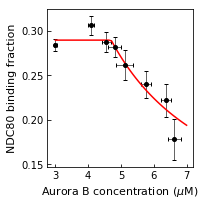

In [8]:
from kapteyn import kmpfit

#Fitting NDC80 binding vs Aurora concentration data
fit = kmpfit.simplefit(binding_vs_Aur_model,[4,20,5],meanX*AuroraPeakConc,meanY,err=semY)

print(fit.params, np.sqrt(np.diag(fit.covar)))

fig = plt.figure(figsize=(3,3))
plt.errorbar(meanX*AuroraPeakConc,meanY,
             xerr=semX*AuroraPeakConc,yerr=semY,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)

# plot fit
xx = np.linspace(3,7,num=50)
yy = binding_vs_Aur_model(fit.params,xx)
plt.plot(xx,yy,'r-')

plt.xlabel('Aurora B concentration ($\mu$M)',fontsize=fs)

plt.ylabel('NDC80 binding fraction',fontsize=fs)

ax = plt.gca()
ax.tick_params(direction='in')
ax.set_xticks([3,4,5,6,7])

plt.tight_layout()

fig.savefig('AuroraB_vs_NDC80bindingfraction_binned_w_fit.pdf',edgecolor=None,facecolor=None)

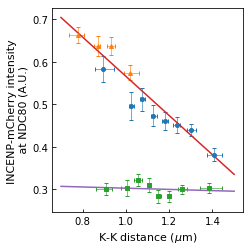

In [9]:
# Plot only intensity at KT, because that's meaningful. Add linear model
fig = plt.figure(figsize=(3.6,3.6))

fmts = ['o','^','s']
grps = ['DMSO','Taxol','5ITu']
fs = 11
ms=4
ew = 0.6
for j,df_res in enumerate(df_res_list):
    plt.errorbar(df_res['kkdist_q2']*pixsize,df_res['avgnormint560'],
                 xerr=np.array([df_res['kkdist_q2']-df_res['kkdist_q1'],df_res['kkdist_q3']-df_res['kkdist_q2']])*pixsize,
                 yerr=df_res['semnormint560'],fmt=fmts[j],capsize=2,mec=None,ms=ms,elinewidth=ew,label=grps[j])

#fit linear model
linmodel = lambda x,a,b:a*x+b
#taxol + DMSO
popt1,pconv1 = sp.optimize.curve_fit(linmodel,
                      np.concatenate([df_res_list[0]['kkdist_q2'].values,df_res_list[1]['kkdist_q2'].values])*pixsize,
                      np.concatenate([df_res_list[0]['avgnormint560'],df_res_list[1]['avgnormint560']]),
                     sigma=np.concatenate([df_res_list[0]['semnormint560'],df_res_list[1]['semnormint560']]))
#5ITu
popt2,pconv2 = sp.optimize.curve_fit(linmodel,df_res_list[2]['kkdist_q2'].values*pixsize,
                                     df_res_list[2]['avgnormint560'],sigma=df_res_list[2]['semnormint560'])

#only DMSO
popt3,pconv3 = sp.optimize.curve_fit(linmodel,df_res_list[0]['kkdist_q2'].values*pixsize,
                      df_res_list[0]['avgnormint560'],sigma=df_res_list[0]['semnormint560'])


xx = np.linspace(0.7,1.5,num=50)
plt.plot(xx,linmodel(xx,*popt1),label='Fit DMSO+Taxol')
plt.plot(xx,linmodel(xx,*popt2),label='Fit 5ITu')

plt.ylabel('INCENP-mCherry intensity\n at NDC80 (A.U.)',fontsize=fs)
plt.xlabel('K-K distance ($\mu$m)',fontsize=fs)
#plt.legend(fontsize=fs,loc='center left')

ax = plt.gca()
ax.tick_params(direction='in')

plt.tight_layout()

fig.savefig('INCENP-mCherry intensity vs KKDistance.pdf',facecolor=None,edgecolor=None)


In [10]:
print(popt1,popt2)
print(fit.params)

[-0.46147658  1.02668672] [-0.01433296  0.3163001 ]
[3.5265095225240914, 19.42964805390698, 4.7004721845012609]


In [11]:
# p value estimation

from scipy.stats.distributions import  t

n = 8    # number of data points
pcov = pconv3 
pars = popt3


alpha = 1e-4 # confidence interval = 100*(1-alpha)

p = len(pars) # number of parameters

dof = max(0, n - p) # number of degrees of freedom

# student-t value for the dof and confidence level
tval = t.ppf(1.0-alpha/2., dof) 

for i, p, var in zip(range(n), pars, np.diag(pcov)):
    sigma = var**0.5
    print('p[%d]: %03f [%03f %03f]' %(i,p,p - sigma*tval,p + sigma*tval))

p[0]: -0.348127 [-0.645361 -0.050894]
p[1]: 0.878070 [0.507859 1.248281]


### p-vals: DMSO + Taxol, p < 1e-6; 5ITu, p > 0.5; DMSO only, p < 1e-4

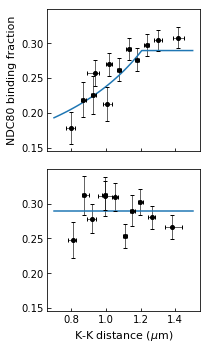

In [15]:
K,Kphos,C = fit.params
convfactor = 0.42
ms=4
ew = 0.6

# a*K-K distance + b = Aurora B concentration, 1 for DMSO+5ITu; 2 for 5ITu
a1,b1 = AuroraPeakConc*popt1
a2,b2 = AuroraPeakConc*popt2

kkdists = np.linspace(0.7,1.5,num=50) #kkdists 
Aur1 = a1*kkdists+b1
Aur2 = a2*kkdists+b2

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(3,5),sharex=True,sharey=True)

# NDC80 binding vs kkdist model
ax[0].plot(kkdists,binding_vs_Aur_model([K,Kphos,C],Aur1))
ax[1].plot(kkdists,binding_vs_Aur_model([K,Kphos,C],Aur2))

fFRET1 = np.concatenate([FLIMTaxol['mean_FRET_fraction'],FLIMWT['mean_FRET_fraction']])
dfFRET1 = np.concatenate([FLIMTaxol['std_FRET_fraction'],FLIMWT['std_FRET_fraction']])
fFRET2 = np.concatenate([FLIMDbl['mean_FRET_fraction'],FLIM5ITu['mean_FRET_fraction']])
dfFRET2 = np.concatenate([FLIMDbl['std_FRET_fraction'],FLIM5ITu['std_FRET_fraction']])

#plot data
X1 = np.concatenate([FLIMTaxol['X'],FLIMWT['X']])
Y1 = fFRET1/convfactor
dX1up = np.concatenate([FLIMTaxol['Xq3']-FLIMTaxol['X'],FLIMWT['Xq3']-FLIMWT['X']])
dX1down = np.concatenate([FLIMTaxol['X']-FLIMTaxol['Xq1'],FLIMWT['X']-FLIMWT['Xq1']])
dY1 = dfFRET1/convfactor

X2 = np.concatenate([FLIMDbl['X'],FLIM5ITu['X']])
Y2 = fFRET2/convfactor
dX2up = np.concatenate([FLIMDbl['Xq3']-FLIMDbl['X'],FLIM5ITu['Xq3']-FLIM5ITu['X']])
dX2down = np.concatenate([FLIMDbl['X']-FLIMDbl['Xq1'],FLIM5ITu['X']-FLIM5ITu['Xq1']])
dY2 = dfFRET2/convfactor

ax[0].errorbar(X1,Y1,xerr=[dX1down,dX1up],yerr=dY1,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)
ax[1].errorbar(X2,Y2,xerr=[dX2down,dX2up],yerr=dY2,fmt='o',color='k',capsize=2,mec=None,ms=ms,elinewidth=ew)

ax[0].set_ylabel('NDC80 binding fraction',fontsize=11)
ax[1].set_xlabel('K-K distance ($\mu$m)',fontsize=11)

ax[0].tick_params(direction='in')
ax[1].tick_params(direction='in')

plt.tight_layout()

fig.savefig('NDC80Binidng_vs_KKdist_w_model.pdf',facecolor=None,edgecolor=None)
